In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# What do we want to do? 
We’ll need to create an operational definition of the "bout:  

1.) We’ll need to set a minimum threshold over baseline in which the bout begins. 

- Let’s start with 0.001V.  
- Note: This may need to be actively adjusted per animal given variance in noise each day. 

2.) Once the threshold goes back to baseline (under threshold) we’ll have to set a minimum duration for how long it must stay under threshold for the bout to end.  

- Let’s start with 0.5 seconds.  

 

For analysis of each bout, we’ll want metrics generated for: 

1) Duration of bout 

2) Peak velocity 

3) AVG velocity 

4) Peak acceleration 

5) AVG acceleration 


# What does our data look like? 
 ‘Channel_05’ is the raw velocity and ‘Channel_05_ts_step’ is the sampling frequency (1000 Hz, i.e. 1 ms, which should be the same for all files). 'Channel_05' should be a continuous trace. 

In [2]:
voltage_cutoff = .01
minumum_duration = 5

# Import Data 
First, we're going to use the scipy function `loadmat` to import our `.mat` file. 

In [3]:
data = loadmat('WT - DAY 5.mat')
data['Channel_05'] = -data['Channel_05']

Now, let's explore our data file a little. 

In [4]:
type(data)

dict

Ok, looks our data is formatted as a dictionary, so what are the keys of this dictionary? 

In [20]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_05', 'Channel_05_ind', 'Channel_05_ts', 'Channel_05_ts_step'])

In [21]:
data['Channel_05_ts']

array([[0]], dtype=uint8)

In [22]:
data['Channel_05_ts_step']

array([[0.0001]])

In [6]:
sampling_rate_hz = int(1/data['Channel_05_ts_step'][0][0])
data['Channel_05'][:sampling_rate_hz * 60].shape

(600000, 1)

In [24]:
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

Text(12.25, 0.5, 'Voltage')

In the plot above, we plot Voltage against Seconds, where we see a single movement bout. Let's see what happens if we just start and end a bout whenever Voltage is above .1

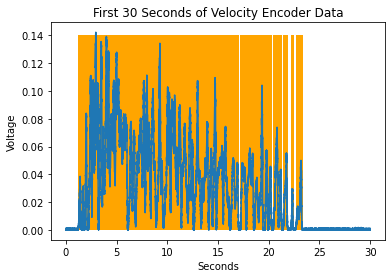

In [10]:

above_cutoff = data['Channel_05'] > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.savefig('example.png')
plt.show()

That actually works pretty well, but we have to account for those small gaps - how do we do that? We need to implement the minimum length of time our velocity encoder has to fall below the threshold. This is encoded by the `minimum_duration`. To get the number of timesteps that we need to look out for, we need to multiply `minimum_duration` by `sampling_rate_hz`. Then, for every `TRUE` value in `above_cutoff` (this is a boolean array with `TRUE` if it's above the cutoff and `FALSE` if it's below), we check if the next `minimum_duration` * `sampling_rate_hz` time steps are `FALSE`. If they are, we can stop the movement epoch. If they aren't, we continue until the next `TRUE`, where we start checking again. 

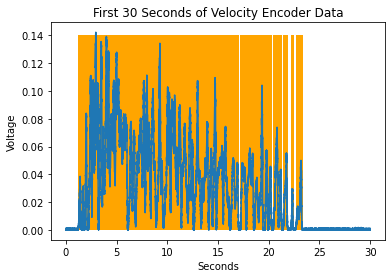

In [7]:
above_cutoff = data['Channel_05'] > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.savefig('example.png')
plt.show()

In [8]:
True_followed_by_false = above_cutoff[:-1] * (1 - above_cutoff[1:]) # this gives us an array of bbolean values whenever there is a True followed by a False
indices = np.where(True_followed_by_false == 1)[0] + 1 # this converts the array of boolean values to a list of indices
for i, idx in enumerate(indices): 
    """
    We want to check if the next minumum_duration of seconds are
    all False
    """
    end_of_array = above_cutoff.shape[0] - 1
    curr_slice = above_cutoff[idx: min(idx + (minumum_duration * sampling_rate_hz), end_of_array)]
    if np.sum(curr_slice) > 10: # if there are more than 10 times it breaks the cutoff 
        if i + 1 != len(indices):
            end = min((minumum_duration * sampling_rate_hz), (indices[i + 1] - idx))
        else: 
            end = min((minumum_duration * sampling_rate_hz), len(above_cutoff) - idx - 1)
        above_cutoff[idx: idx + end] = np.array([True] * end).reshape(-1, 1)
        


In [9]:
def plot_trace(start, end, sampling_rate_hz, above_cutoff, data, save_name = ''):
    %matplotlib widget
    start_idx = sampling_rate_hz  * start
    end_idx = sampling_rate_hz * end
    xaxis = np.arange(sampling_rate_hz * (end - start))
    plt.vlines(start + xaxis[above_cutoff[start_idx:end_idx].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange')
    plt.plot(start + xaxis/sampling_rate_hz, data['Channel_05'][start_idx:end_idx], label = 'Signal')
    plt.title('Velocity Encoder Data from {} to {} seconds'.format(start, end))
    plt.xlabel('Seconds')
    #plt.ion()
    plt.ylabel('Voltage')
    plt.legend()
    if save_name != '':
        plt.savefig(save_name)

    plt.show()

In [10]:
plot_trace(200, 500, sampling_rate_hz, above_cutoff, data, save_name = '')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [40]:
above_cutoff[0*sampling_rate_hz:30*sampling_rate_hz].shape

(300000, 1)

  Using cached parso-0.8.1-py2.py3-none-any.whl (93 kB)
  Attempting uninstall: parso
    Found existing installation: parso 0.7.0
    Uninstalling parso-0.7.0:
      Successfully uninstalled parso-0.7.0
